# Лабораторна робота 3
##### Виконала *Ваховська Віра Миколаївна*

##### Тема:
Аналіз та прогнозування випадків туберкульозу в Індії за допомогою регресійних моделей

##### 1. Попередня обробка даних:
1. Завантажити та оглянути набір даних.
2. Перевірити наявність пропущених значень.
3. Видалити або заповнити пропущені значення (за потреби).
4. Виключити нерелевантні змінні (наприклад, текстові колонки).
5. Виконати стандартизацію числових даних.
##### 2. Аналіз даних:
1. Дослідити кореляції між змінними за допомогою теплової карти.
2. Зобразити розподіл цільової змінної (“TB case notification total”).
3. Побудувати парні графіки (scatter plots) між ключовими факторами та цільовою змінною.
##### 3. Лінійна регресія:
1. Реалізувати та навчити Лінійну регресію
2. Виконати прогнозування на навчальні та тестовій вибірці та з використанням крос валідації.
3. Оцінити точність моделей за метриками RMSE та R².
##### 4. Регуляризація:
1. Використати Lasso та Ridge регресії.
2. Оптимізувати гіперпараметри “alpha” для Lasso та Ridge за допомогою GridSearchCV.
##### 5. Визначення ключових факторів:
1. Використати модель отримані лінійні регресії для оцінки ваги кожного фактора для всіх моделей.
2. Побудувати діаграму важливості факторів на основі ваг коефіцієнтів моделі.
##### 6. Побудова та порівняння моделей:
1. Передбачити щоб код можна було легко доповнювати новими моделями без зміни самої
структури коду. Реалізувати такі моделі:
- Дерево рішень
- Метод найближчих сусідів
- Метод опорних векторів (SVM)
- Випадковий ліс
2. Виконати прогнозування на навчальні і та тестовій вибірці для кожної моделі.
3. Оцінити точність моделей за метриками RMSE та R².
##### 7. Порівняльний аналіз:
1. Побудувати таблицю з результатами (RMSE, R²) для всіх моделей.
2. Візуалізувати порівняння точності моделей у вигляді стовпчастого графіка.
3. Зробити висновки про фактори, які найбільше впливають на прогноз в залежності від моделі.

# Хід роботи

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [2]:
file_path = "filled_final_data.xlsx"
df = pd.read_excel(file_path)
print(df.head())

                        City  Year  \
0  Andaman & Nicobar Islands  2019   
1             Andhra Pradesh  2019   
2          Arunachal Pradesh  2019   
3                      Assam  2019   
4                      Bihar  2019   

   Active Case Finding TB cases diagnosed among tested  \
0                                                  6     
1                                               1771     
2                                                 27     
3                                                547     
4                                               2483     

   Active Case Finding TB Presumptive TB cases tested out of those screened  \
0                                                103                          
1                                              35785                          
2                                               1535                          
3                                               7114                          
4                          

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 26 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   City                                                                      148 non-null    object 
 1   Year                                                                      148 non-null    int64  
 2   Active Case Finding TB cases diagnosed among tested                       148 non-null    int64  
 3   Active Case Finding TB Presumptive TB cases tested out of those screened  148 non-null    int64  
 4   MDR/RR TB DIAGNOSED MDR/RR patient diagnosed                              148 non-null    int64  
 5   Paediatric TB patients notified                                           148 non-null    int64  
 6   TB case notification total                                        

1. **City**: Назва регіону/міста. Це категоріальна змінна, що вказує на географічну локацію.
2. **Year**: Рік збору даних.
Дані про діагностику та випадки:
3. **Active Case Finding TB cases diagnosed among tested**: Кількість підтверджених випадків ТБ серед обстежених.
4. **Active Case Finding TB Presumptive TB cases tested out of those screened**: Кількість людей, у яких передбачувано був ТБ, які пройшли тестування.
Дані про резистентний ТБ:
5. **MDR/RR TB DIAGNOSED MDR/RR patient diagnosed**: Кількість діагностованих випадків мультирезистентного ТБ (MDR/RR-TB).
Педіатричний ТБ:
6. **Paediatric TB patients notified**: Кількість дітей із ТБ.
7. **Treatment outcome of Paediatric TB patients notified in (Death Rate)**: Смертність серед дітей із ТБ.
8. **Treatment outcome of Paediatric TB patients notified in (Success Rate)**: Успішність лікування дітей із ТБ.
Статистика реєстрації:
9. **TB case notification total**: Загальна кількість зареєстрованих випадків ТБ.
10. **TB Cases Notified Female**: Кількість випадків ТБ серед жінок.
11. **TB Cases Notified Male**: Кількість випадків ТБ серед чоловіків.
Результати лікування:
12. **Treatment outcome of TB patients notified in (% Lost to follow up)**: Відсоток пацієнтів із ТБ, які припинили лікування або зникли з-під спостереження.
13. **Treatment outcome of TB patients notified in (Treatment Failure Rate)**: Відсоток пацієнтів із невдалою спробою лікування ТБ.
Дані про ВІЛ та ТБ:
22. **TB patients with known HIV status**: Пацієнти з відомим статусом ВІЛ.
15. **TB-HIV co-infected patients Diagnosed**: Кількість пацієнтів, які мають одночасно ТБ і ВІЛ. Дозволяє оцінити перетин епідемій.
16. **TB-HIV co-infected patients Put on ART**: Кількість пацієнтів з ко-інфекцією ТБ і ВІЛ, які розпочали антиретровірусну терапію (ART).
17. **Treatment outcome of TB-HIV patients notified in (Death Rate)**: Смертність серед пацієнтів із ВІЛ/ТБ.
22. **Treatment outcome of TB-HIV patients notified in (Success Rate)**: Успішність лікування пацієнтів із ВІЛ/ТБ.
Супутні фактори:
18. **TB patients with known Tobacco usage status**: Пацієнти з відомим статусом використання тютюну.
19. **TB patients with known Alcohol usage status**: Пацієнти з відомим статусом вживання алкоголю.
20. **TB - DM PaTB- DM patients initiated on Anti-diabetic treatment**: Пацієнти з ТБ і діабетом, які розпочали лікування діабету. 
21. **Pregnant TB patients identified**: Кількість вагітних жінок, у яких діагностовано ТБ
Інфраструктура:
23. **PMDT- Infrastructure No. of Nodal DR-TB centres**: Кількість центрів для лікування мультирезистентного ТБ.
COVID 19 і ТБ:
24. **TB-COVID 19 patients detected**: Пацієнти, у яких було діагностовано ТБ та COVID-19.

In [4]:
object_columns = df.select_dtypes(include=['object']).columns
for col in object_columns:
    print(f"Unique values in '{col}':")
    print(df[col].unique())

Unique values in 'City':
['Andaman & Nicobar Islands' 'Andhra Pradesh' 'Arunachal Pradesh' 'Assam'
 'Bihar' 'Chandigarh' 'Chhattisgarh' 'Dadra and Nagar Haveli' 'Delhi'
 'Goa' 'Gujarat' 'Haryana' 'Himachal Pradesh' 'Jammu & Kashmir'
 'Jharkhand' 'Karnataka' 'Kerala' 'Ladakh' 'Lakshadweep' 'Madhya Pradesh'
 'Maharashtra' 'Manipur' 'Meghalaya' 'Mizoram' 'Nagaland' 'Odisha'
 'Puducherry' 'Punjab' 'Rajasthan' 'Sikkim' 'Tamil Nadu' 'Telangana'
 'Tripura' 'Uttar Pradesh' 'Uttarakhand' 'West Bengal' 'INDIA']


In [5]:
# Отримуємо унікальні роки з датафрейму
expected_years = set(df['Year'].unique())

# Групуємо по містах та агрегуємо роки
city_years = df.groupby('City')['Year'].unique().reset_index()

# Перейменовуємо стовпці для зручності
city_years.columns = ['City', 'Years']

# Flag для перевірки, чи є відсутні роки
all_good = True

# Перевіряємо відсутні роки
for index, row in city_years.iterrows():
    city = row['City']
    years_present = set(row['Years'])
    missing_years = expected_years - years_present

    if missing_years:
        print(f"City: {city}, Missing Years: {', '.join(map(str, missing_years))}")
        all_good = False

# Якщо не було відсутніх років, виводимо "Good"
if all_good:
    print("Good")

Good


In [6]:
# Перевірити відсутні значення
missing_values = df.isnull().sum()

# Показати колонки з відсутніми значеннями
if (missing_values == 0).all():
    print("Good")
else:
    print("Columns with missing values:")
    print(missing_values[missing_values > 0])

Good


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 26 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   City                                                                      148 non-null    object 
 1   Year                                                                      148 non-null    int64  
 2   Active Case Finding TB cases diagnosed among tested                       148 non-null    int64  
 3   Active Case Finding TB Presumptive TB cases tested out of those screened  148 non-null    int64  
 4   MDR/RR TB DIAGNOSED MDR/RR patient diagnosed                              148 non-null    int64  
 5   Paediatric TB patients notified                                           148 non-null    int64  
 6   TB case notification total                                        

In [8]:
# Дані за 2019 рік сильно відрізняються за інші роки
# df = df[df['Year'] != 2019]

In [9]:
df = df.drop(columns=['City', 'Year'])

In [10]:
# Застосовуємо стандартизацію до числових колонок
scaler = StandardScaler()
df_scaled = df.astype('int64').copy()
df_scaled[df.columns] = scaler.fit_transform(df_scaled)

# Перевіряємо результат
print("\nСтандартизовані дані:")
print(df_scaled[df.columns].describe())


Стандартизовані дані:
       Active Case Finding TB cases diagnosed among tested  \
count                                       1.480000e+02     
mean                                        2.400482e-17     
std                                         1.003396e+00     
min                                        -3.247444e-01     
25%                                        -3.218369e-01     
50%                                        -2.938460e-01     
75%                                        -1.276503e-01     
max                                         6.946175e+00     

       Active Case Finding TB Presumptive TB cases tested out of those screened  \
count                                       1.480000e+02                          
mean                                       -2.400482e-17                          
std                                         1.003396e+00                          
min                                        -3.260594e-01                          
25%

In [11]:
df_scaled.head(2)

,Active Case Finding TB cases diagnosed among tested,Active Case Finding TB Presumptive TB cases tested out of those screened,MDR/RR TB DIAGNOSED MDR/RR patient diagnosed,Paediatric TB patients notified,TB case notification total,TB Cases Notified Female,TB Cases Notified Male,TB patients with known Tobacco usage status,TB-HIV co-infected patients Diagnosed,TB-HIV co-infected patients Put on ART,...,Treatment outcome of TB-HIV patients notified in (Death Rate),Treatment outcome of TB-HIV patients notified in (Success Rate),PMDT- Infrastructure No. of Nodal DR-TB centres,TB- DM patients initiated on Anti-diabetic treatment,Treatment outcome of Paediatric TB patients notified in (Death Rate),Treatment outcome of Paediatric TB patients notified in (Success Rate),Pregnant TB patients identified,TB - DM Patients diagnosed among tested,TB patients with known Alcohol usage status,TB-COVID 19 patients detected
0,-0.324153,-0.325696,-0.318015,-0.324145,-0.225045,-0.328029,-0.328406,-0.295938,-0.326888,-0.326734,...,-0.282295,-0.264793,-0.298774,-0.317590,-0.321163,-0.326990,-0.311416,-0.328812,-0.331234,-0.331636
1,-0.150196,-0.199876,-0.116864,-0.145497,0.104724,-0.096217,-0.031900,-0.114847,0.690992,0.674568,...,-0.266197,-0.262760,-0.183220,0.089915,-0.238889,-0.154347,-0.132071,0.075674,-0.016135,-0.023902


### 2. Аналіз даних:

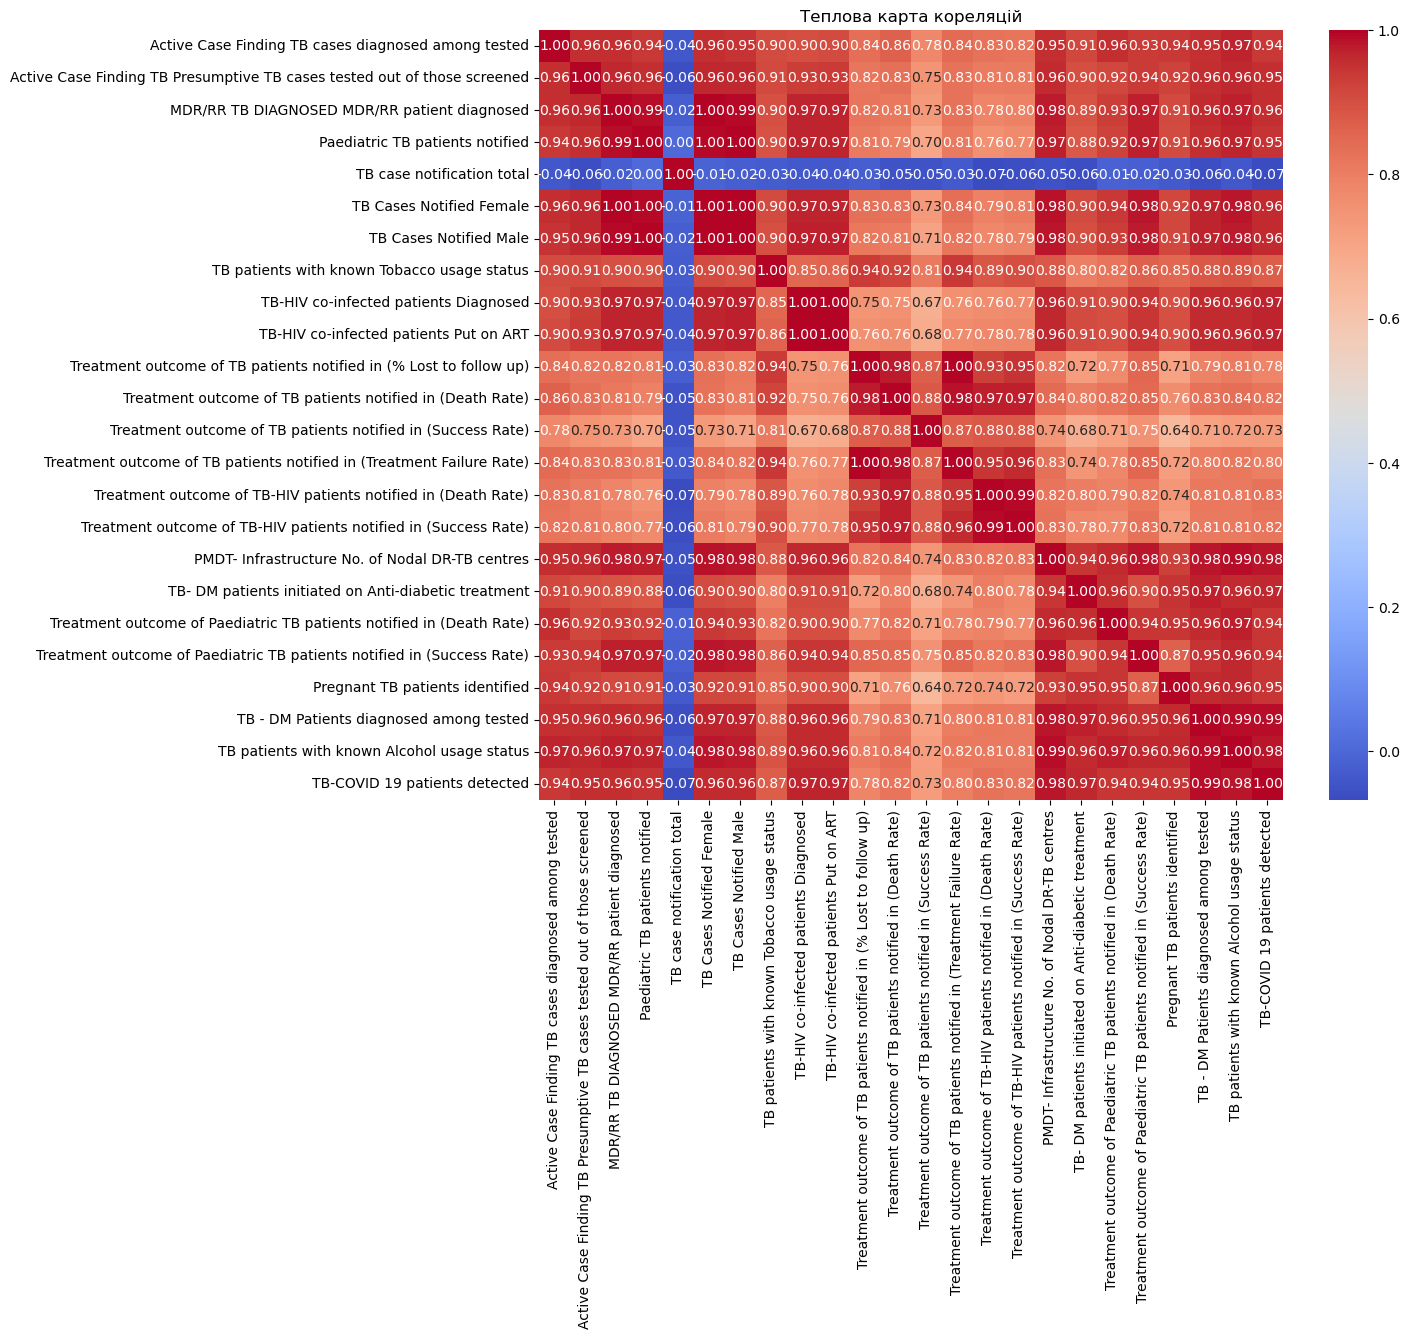

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Кореляційна матриця
correlation_matrix = df_scaled.corr()

# Теплова карта
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Теплова карта кореляцій")
plt.show()

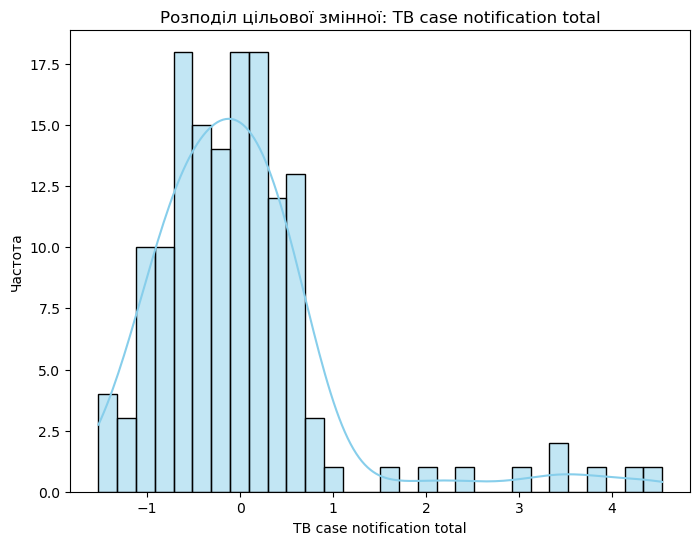

In [13]:
# 2. Розподіл цільової змінної
target_variable = 'TB case notification total'

plt.figure(figsize=(8, 6))
sns.histplot(df_scaled[target_variable], kde=True, bins=30, color='skyblue')
plt.title(f"Розподіл цільової змінної: {target_variable}")
plt.xlabel(target_variable)
plt.ylabel("Частота")
plt.show()

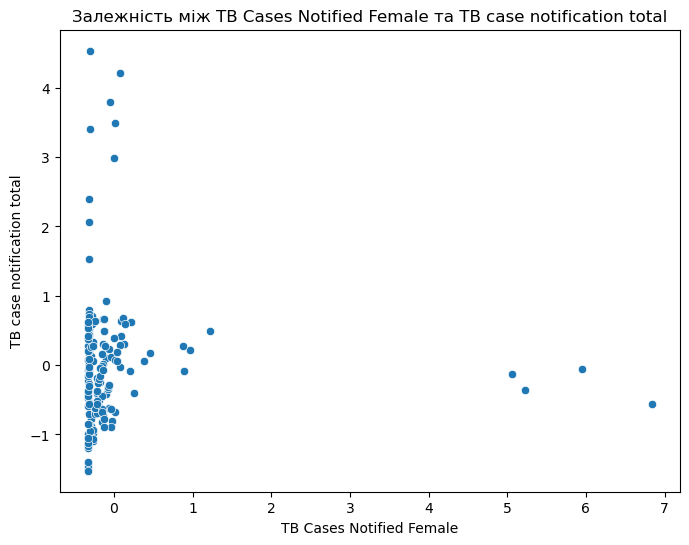

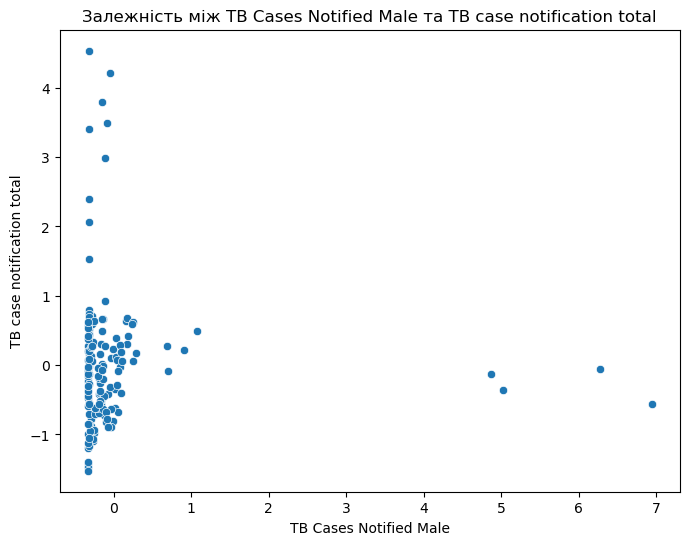

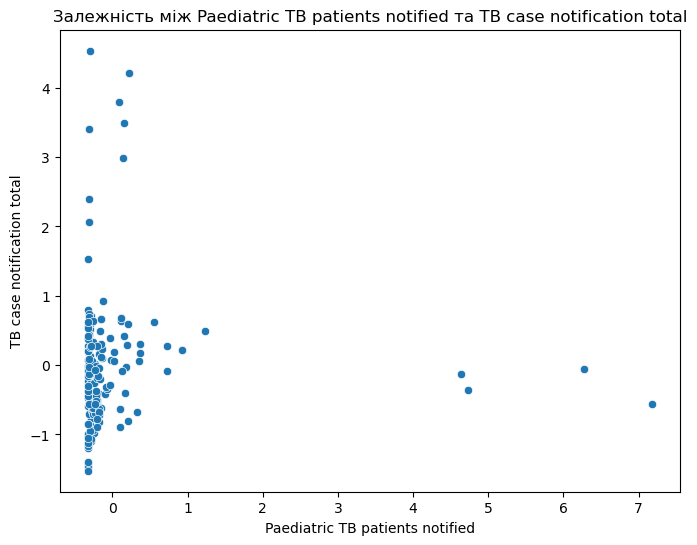

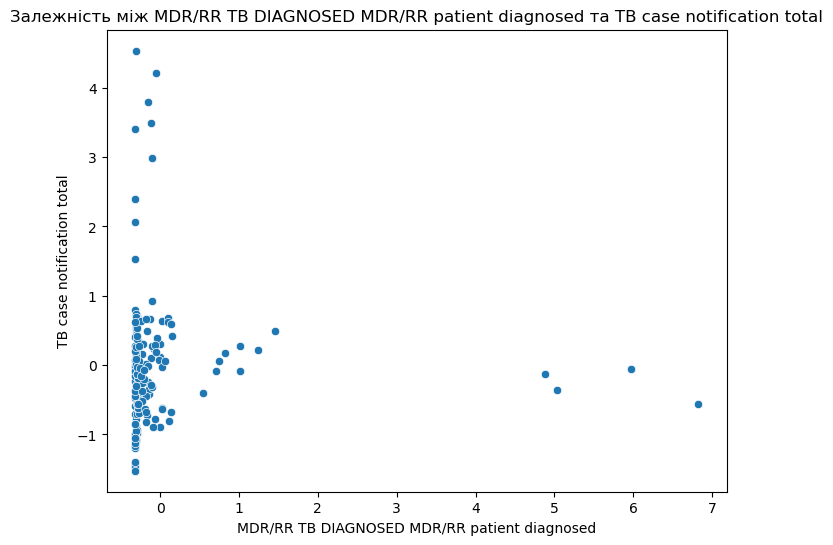

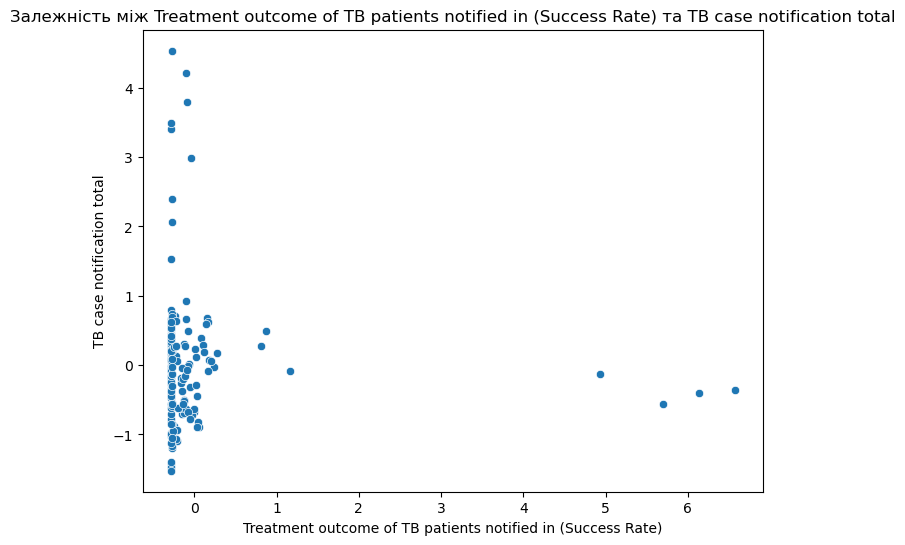

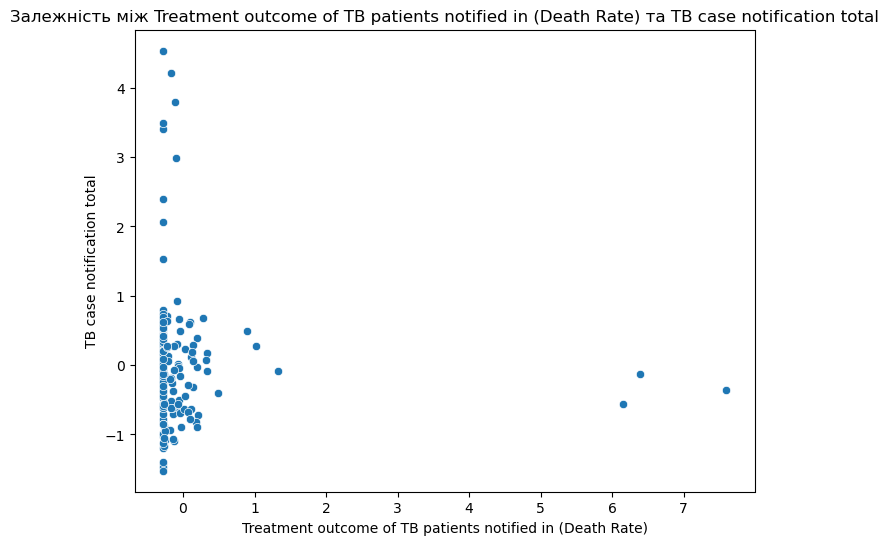

In [14]:
# 3. Парні графіки для ключових факторів
key_factors = [
    'TB Cases Notified Female',
    'TB Cases Notified Male',
    'Paediatric TB patients notified',
    'MDR/RR TB DIAGNOSED MDR/RR patient diagnosed',
    'Treatment outcome of TB patients notified in (Success Rate)',
    'Treatment outcome of TB patients notified in (Death Rate)',
]

for factor in key_factors:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_scaled, x=factor, y=target_variable)
    plt.title(f"Залежність між {factor} та {target_variable}")
    plt.xlabel(factor)
    plt.ylabel(target_variable)
    plt.show()

### 3. Лінійна регресія

In [15]:
# Розділяємо дані на ознаки (X) та цільову змінну (y)
X = df_scaled.drop(columns=['TB case notification total'])  # Виключаємо цільову змінну
y = df_scaled['TB case notification total']

# Розділяємо на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ініціалізуємо модель лінійної регресії
model = LinearRegression()

# Навчаємо модель на тренувальних даних
model.fit(X_train, y_train)

LinearRegression()

In [16]:
# Прогнозуємо для тренувальних та тестових даних
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Виконуємо крос-валідацію
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

In [17]:
# Розрахунок метрик
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Створюємо DataFrame для результатів
results_df = pd.DataFrame({
    'Train MSE': [mean_squared_error(y_train, y_train_pred)],
    'Test MSE': [mean_squared_error(y_test, y_test_pred)],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
}, index=['Linear Regression'])

# Вивід результатів
print(results_df)

                   Train MSE  Test MSE  Train R²   Test R²
Linear Regression   0.680147  1.686715  0.306426 -0.569743


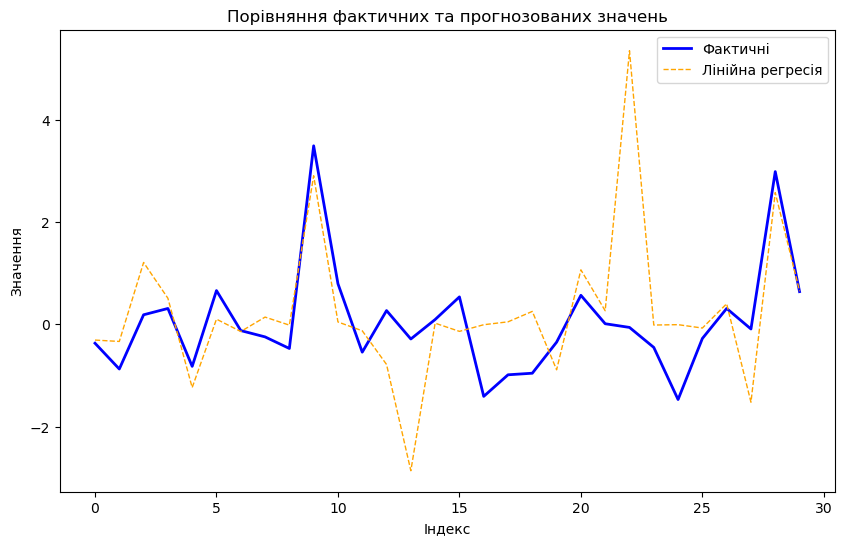

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Фактичні", color='blue', linestyle='-', linewidth=2)
plt.plot(y_test_pred, label="Лінійна регресія", color='orange', linestyle='--', linewidth=1)
plt.legend()
plt.xlabel("Індекс")
plt.ylabel("Значення")
plt.title("Порівняння фактичних та прогнозованих значень")
plt.show()

### 4. Регуляризація

In [19]:
# Гіперпараметри для оптимізації
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [20]:
# Оптимізація для Lasso
lasso = Lasso(max_iter=100000)
lasso_grid = GridSearchCV(lasso, param_grid, scoring='neg_mean_squared_error', cv=5)
lasso_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(max_iter=100000),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [21]:
# Оптимізація для Ridge
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)
ridge_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [22]:
# Найкращі моделі
best_lasso = lasso_grid.best_estimator_
best_ridge = ridge_grid.best_estimator_

# Найкращі значення alpha
best_alpha_lasso = lasso_grid.best_params_['alpha']
best_alpha_ridge = ridge_grid.best_params_['alpha']

# Прогнозування
lasso_train_pred = best_lasso.predict(X_train)
lasso_test_pred = best_lasso.predict(X_test)
ridge_train_pred = best_ridge.predict(X_train)
ridge_test_pred = best_ridge.predict(X_test)

# Метрики для Lasso
lasso_train_mse = mean_squared_error(y_train, lasso_train_pred)
lasso_test_mse = mean_squared_error(y_test, lasso_test_pred)
lasso_train_r2 = r2_score(y_train, lasso_train_pred)
lasso_test_r2 = r2_score(y_test, lasso_test_pred)

# Метрики для Ridge
ridge_train_mse = mean_squared_error(y_train, ridge_train_pred)
ridge_test_mse = mean_squared_error(y_test, ridge_test_pred)
ridge_train_r2 = r2_score(y_train, ridge_train_pred)
ridge_test_r2 = r2_score(y_test, ridge_test_pred)

In [23]:
# Таблиця результатів
results = pd.DataFrame({
    'Alpha': [best_alpha_lasso, best_alpha_ridge],
    'Train MSE': [lasso_train_mse, ridge_train_mse],
    'Test MSE': [lasso_test_mse, ridge_test_mse],
    'Train R²': [lasso_train_r2, ridge_train_r2],
    'Test R²': [lasso_test_r2, ridge_test_r2]
}, index=['Lasso', 'Ridge'])

print(results)

       Alpha  Train MSE  Test MSE  Train R²   Test R²
Lasso      1   0.980641  1.076558  0.000000 -0.001900
Ridge    100   0.966783  1.060206  0.014132  0.013318


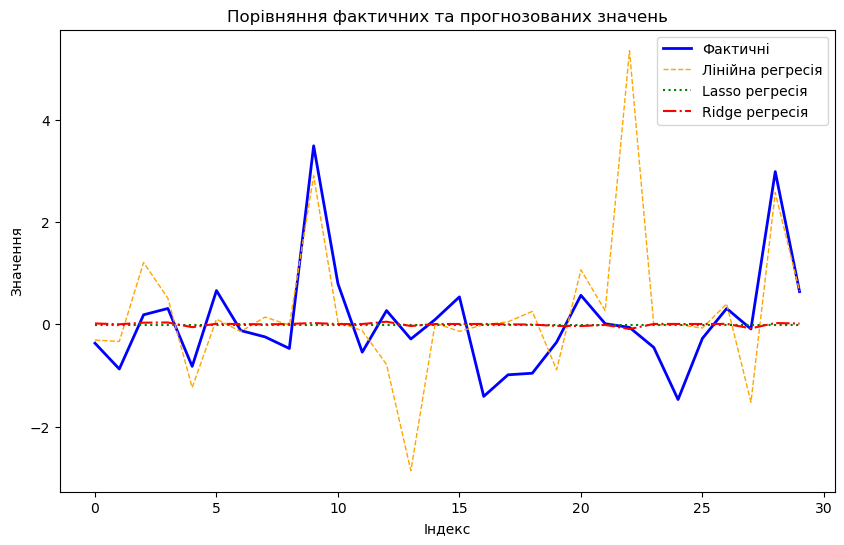

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Фактичні", color='blue', linestyle='-', linewidth=2)
plt.plot(y_test_pred, label="Лінійна регресія", color='orange', linestyle='--', linewidth=1)
plt.plot(lasso_test_pred, label="Lasso регресія", color='green', linestyle=':', linewidth=1.5)
plt.plot(ridge_test_pred, label="Ridge регресія", color='red', linestyle='-.', linewidth=1.5)
plt.legend()
plt.xlabel("Індекс")
plt.ylabel("Значення")
plt.title("Порівняння фактичних та прогнозованих значень")
plt.show()

P.S. При видаленні даних за 2019 рік такого сильного "занулення" не буде.

### 5. Визначення ключових факторів:

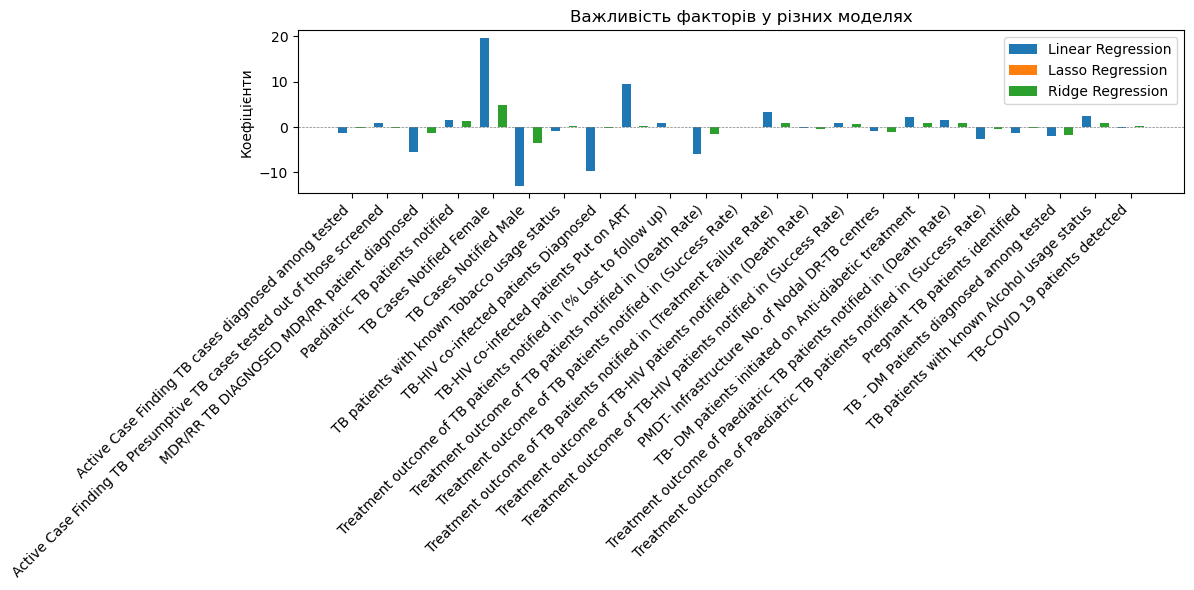

In [25]:
# Оцінка ваг факторів для всіх моделей
def plot_feature_importance(models, model_names, feature_names):
    plt.figure(figsize=(12, 6))
    
    for i, (model, name) in enumerate(zip(models, model_names)):
        coefficients = model.coef_
        plt.bar(np.arange(len(coefficients)) + i * 0.25, coefficients, width=0.25, label=name)
    
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.xticks(np.arange(len(feature_names)) + 0.25, feature_names, rotation=45, ha='right')
    plt.ylabel('Коефіцієнти')
    plt.title('Важливість факторів у різних моделях')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Імена ознак
feature_names = X.columns.tolist()

# Підготовка моделей
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

lasso_model = Lasso(alpha=0.1, max_iter=10000)
lasso_model.fit(X_train, y_train)

ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)

# Візуалізація
plot_feature_importance(
    models=[linear_model, lasso_model, ridge_model],
    model_names=['Linear Regression', 'Lasso Regression', 'Ridge Regression'],
    feature_names=feature_names
)

### 6. Побудова та порівняння моделей:

                   Model  Train RMSE  Test RMSE  Train R²   Test R²
0  DecisionTreeRegressor    0.000000   0.608835  1.000000  0.655026
1    KNeighborsRegressor    0.787411   0.895997  0.367744  0.252864
2                    SVR    0.966328   1.043234  0.047777 -0.012862
3  RandomForestRegressor    0.334145   0.704072  0.886143  0.538660


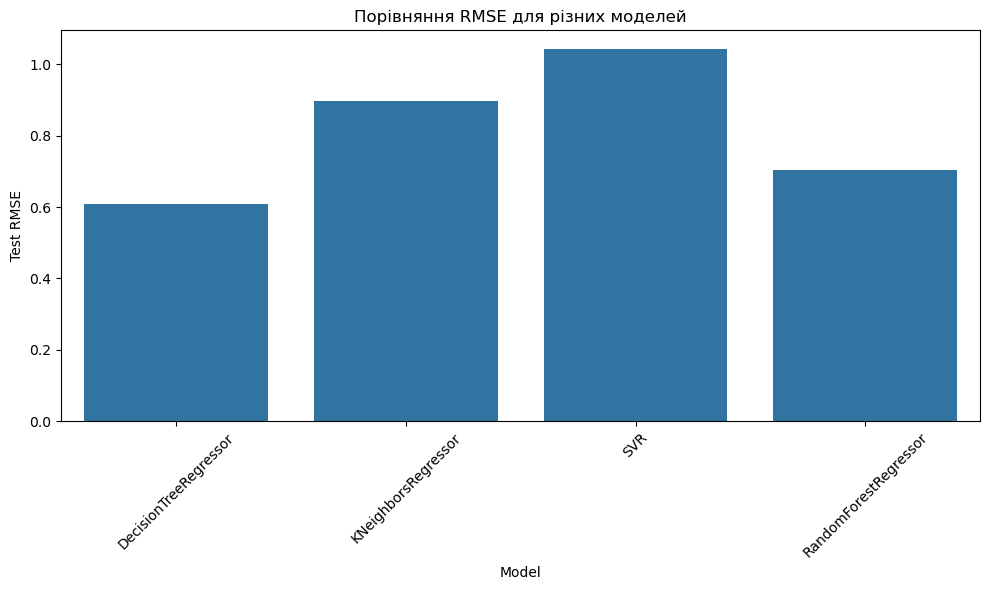

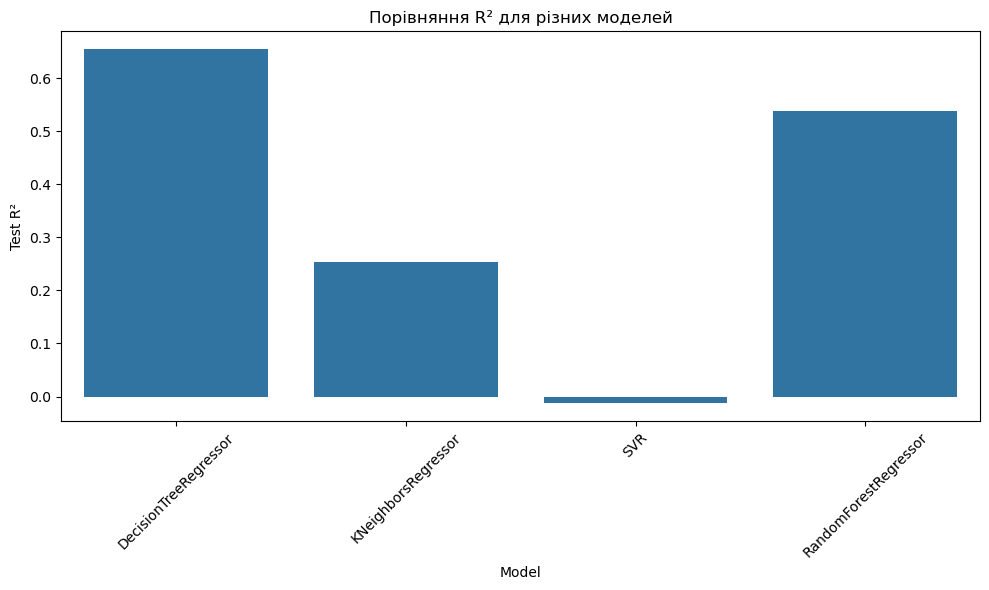

In [26]:
# Функція для навчання і тестування моделі
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    return {
        "Model": model.__class__.__name__,
        "Train RMSE": train_rmse,
        "Test RMSE": test_rmse,
        "Train R²": train_r2,
        "Test R²": test_r2,
        "y_test_pred": y_test_pred
    }

# Словник моделей
model_dict = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "Support Vector Machine": SVR(kernel='linear'),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Оцінка моделей
results = []
model_predictions = {}
for model_name, model in model_dict.items():
    result = evaluate_model(model, X_train, X_test, y_train, y_test)
    results.append({key: result[key] for key in result if key != "y_test_pred"})
    model_predictions[model_name] = result["y_test_pred"]

# Створення DataFrame з результатами
results_df = pd.DataFrame(results)

# Виведення результатів
print(results_df)

# Візуалізація RMSE
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Test RMSE", data=results_df)
plt.title("Порівняння RMSE для різних моделей")
plt.ylabel("Test RMSE")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Візуалізація R²
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Test R²", data=results_df)
plt.title("Порівняння R² для різних моделей")
plt.ylabel("Test R²")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

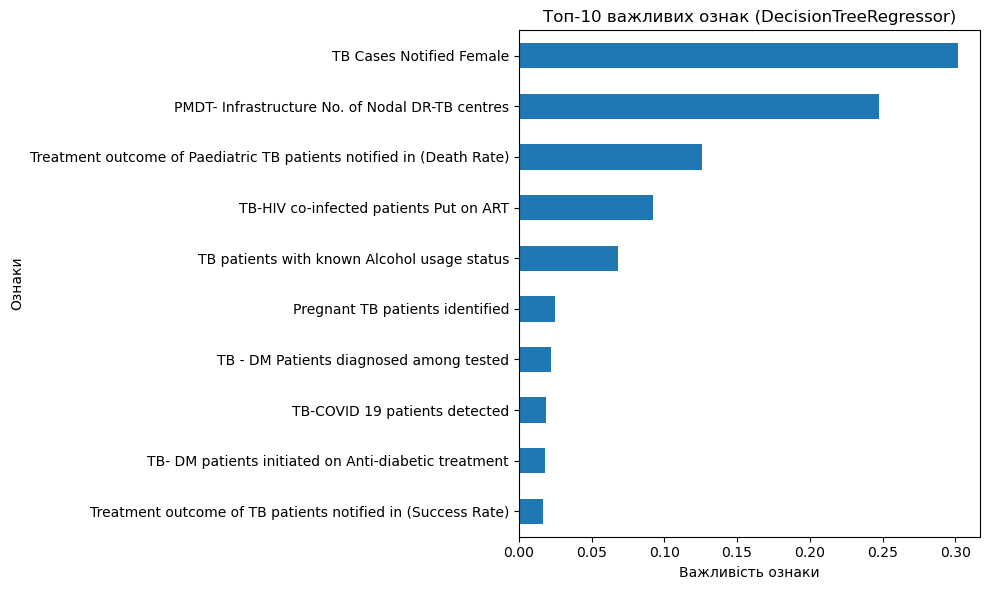

In [27]:
# Оцінка важливості ознак для моделей з підтримкою feature_importances_
def plot_feature_importance(model, X, top_n=10):
    if hasattr(model, "feature_importances_"):
        feat_importances = pd.Series(model.feature_importances_, index=X.columns)
        plt.figure(figsize=(10, 6))
        feat_importances.nlargest(top_n).sort_values(ascending=True).plot(kind='barh')
        plt.title(f"Топ-{top_n} важливих ознак ({model.__class__.__name__})")
        plt.xlabel("Важливість ознаки")
        plt.ylabel("Ознаки")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Модель {model.__class__.__name__} не підтримує 'feature_importances_'.")

# Навчання моделі DecisionTreeRegressor
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Побудова графіка важливості ознак
plot_feature_importance(tree_model, X_train)

### 7. Порівняльний аналіз

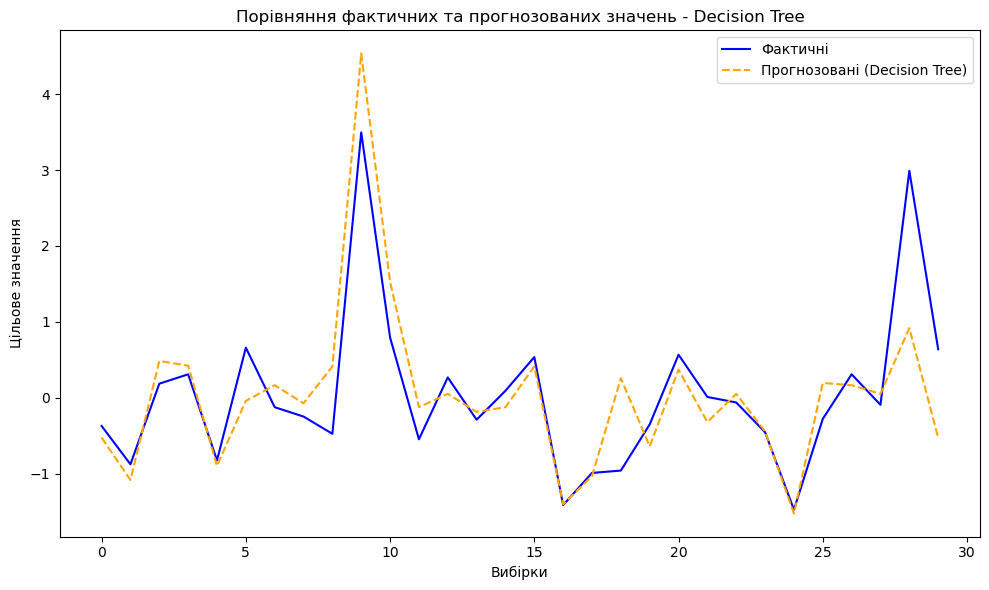

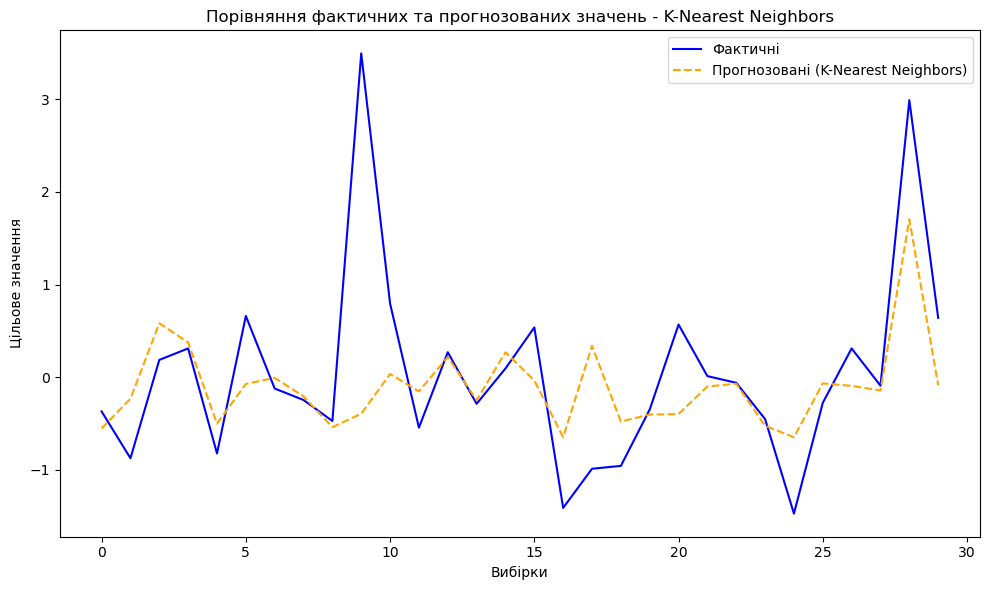

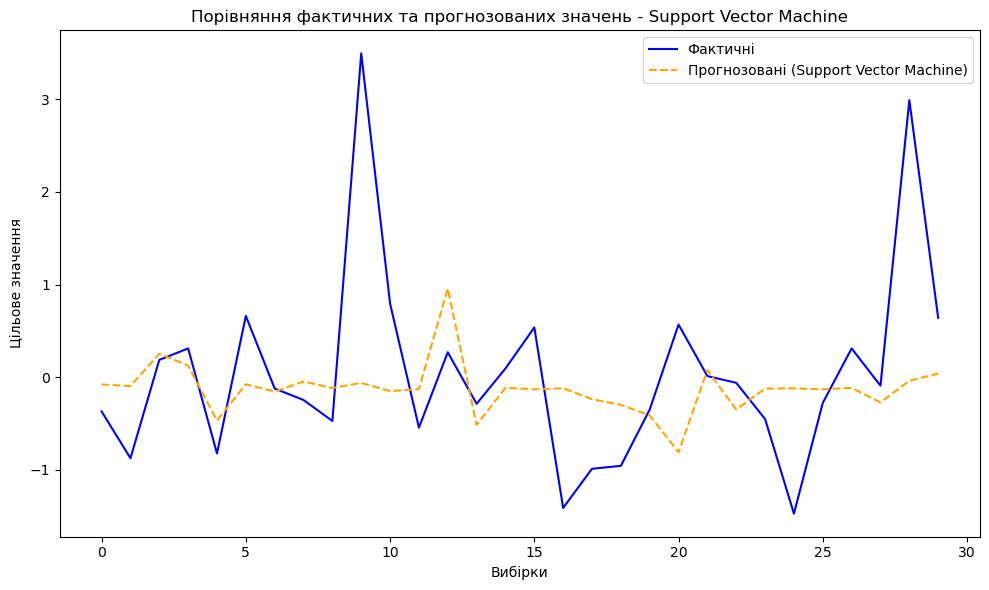

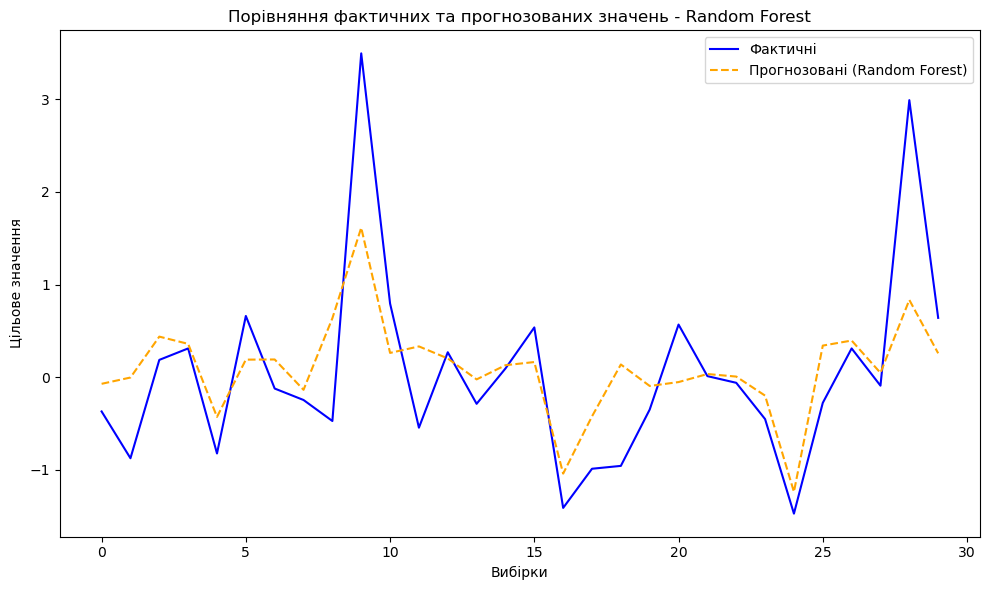

In [28]:
# Візуалізація прогнозів для кожної моделі
for model_name, y_test_pred in model_predictions.items():
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label="Фактичні", color="blue")
    plt.plot(y_test_pred, label=f"Прогнозовані ({model_name})", linestyle="--", color="orange")
    plt.title(f"Порівняння фактичних та прогнозованих значень - {model_name}")
    plt.ylabel("Цільове значення")
    plt.xlabel("Вибірки")
    plt.legend()
    plt.tight_layout()
    plt.show()

**Висновок:** було виконано аналіз та прогнозування випадків туберкульозу в Індії за допомогою регресійних моделей. Спочатку був проведений етап попередньої обробки даних, під час якого здійснили завантаження і перевірку на наявність пропущених значень, що були або видалені, або заповнені відповідно до потреб. Також були виключені нерелевантні змінні, а числові дані стандартизовані для подальшого аналізу.

Після цього було виконано дослідження кореляцій між змінними та побудовані графіки для візуалізації розподілу цільової змінної і зв'язків між ключовими факторами. Лінійна регресія була реалізована для прогнозування, після чого оцінено її точність за допомогою метрик RMSE та R² на навчальних та тестових вибірках.

На етапі регуляризації було використано методи Lasso та Ridge регресій з оптимізацією гіперпараметрів через GridSearchCV. Згодом для кожної моделі були визначені ключові фактори, що впливають на результат, і побудована діаграма важливості факторів.

Моделі для прогнозування були розширені додаванням дерев рішень, методу найближчих сусідів, методів опорних векторів (SVM) і випадкового лісу. Для кожної моделі було виконано прогнозування та оцінено точність за допомогою тих самих метрик.

В результаті порівняльного аналізу точності моделей було побудовано графіки, що дозволили візуально порівняти результати. За підсумками аналізу було зроблено висновки щодо ключових факторів, які найбільше впливають на прогнозування випадків туберкульозу.